In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1) 데이터 준비와 확인

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f11900da090>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

- 데이터의 중복 제거

In [6]:
# 데이터 정제하기
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [8]:
print(train_data.isnull().values.any())

True


In [9]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [10]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


- NaN 결측치 제거

In [11]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [12]:
len(train_data)

146182

In [13]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [14]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [15]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [16]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [17]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


- 한국어 토크나이저로 토큰화
- 불용어 (Stopwords) 제거
- 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [18]:
# 토큰화
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
    
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)


In [19]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [20]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [21]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19417


- X_train, y_train, X_test, y_test

In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [24]:
# empty samples 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


/home/ssac2/anaconda3/envs/k2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 3) 모델구성을 위한 데이터 분석 및 가공

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


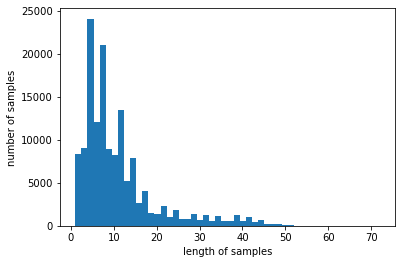

In [25]:
# 패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [27]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [28]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 4) 모델구성 및 validation set 구성

In [29]:
## LSTM으로 네이버 영화 리뷰 감성 분류하기
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))


In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.3895 - acc: 0.8218
Epoch 00001: val_acc improved from -inf to 0.84475, saving model to best_model.h5
1939/1939 [==============================] - 16s 8ms/step - loss: 0.3896 - acc: 0.8217 - val_loss: 0.3552 - val_acc: 0.8448
Epoch 2/15
1936/1939 [============================>.] - ETA: 0s - loss: 0.3263 - acc: 0.8578
Epoch 00002: val_acc improved from 0.84475 to 0.85548, saving model to best_model.h5
1939/1939 [==============================] - 16s 8ms/step - loss: 0.3263 - acc: 0.8577 - val_loss: 0.3329 - val_acc: 0.8555
Epoch 3/15
1935/1939 [============================>.] - ETA: 0s - loss: 0.3005 - acc: 0.8725
Epoch 00003: val_acc improved from 0.85548 to 0.85820, saving model to best_model.h5
1939/1939 [==============================] - 16s 8ms/step - loss: 0.3007 - acc: 0.8723 - val_loss: 0.3289 - val_acc: 0.8582
Epoch 4/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.2822 - acc: 0.8817
Epoc

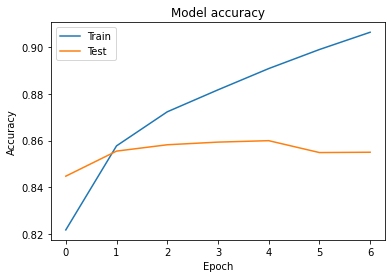

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

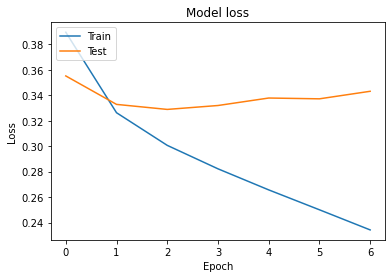

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 2s 2ms/step - loss: 0.3482 - acc: 0.8536

 테스트 정확도: 0.8536


In [36]:
## Multi-Kernel 1D CNN으로 네이버 영화 리뷰 감성 분류하기

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 128
dropout_prob = (0.5, 0.8)
num_filters = 128

model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])


In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_data = (X_test, y_test), verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 00001: val_acc improved from -inf to 0.83909, saving model to CNN_model.h5
2272/2272 - 52s - loss: 0.4270 - acc: 0.7974 - val_loss: 0.3674 - val_acc: 0.8391
Epoch 2/10

Epoch 00002: val_acc improved from 0.83909 to 0.84300, saving model to CNN_model.h5
2272/2272 - 43s - loss: 0.3459 - acc: 0.8511 - val_loss: 0.3563 - val_acc: 0.8430
Epoch 3/10

Epoch 00003: val_acc improved from 0.84300 to 0.84335, saving model to CNN_model.h5
2272/2272 - 45s - loss: 0.3159 - acc: 0.8669 - val_loss: 0.3570 - val_acc: 0.8434
Epoch 4/10

Epoch 00004: val_acc did not improve from 0.84335
2272/2272 - 47s - loss: 0.2942 - acc: 0.8765 - val_loss: 0.3587 - val_acc: 0.8431
Epoch 5/10

Epoch 00005: val_acc did not improve from 0.84335
2272/2272 - 44s - loss: 0.2757 - acc: 0.8855 - val_loss: 0.3604 - val_acc: 0.8414
Epoch 6/10

Epoch 00006: val_acc did not improve from 0.84335
2272/2272 - 46s - loss: 0.2601 - acc: 0.8924 - val_loss: 0.3722 - val_acc: 0.8411
Epoch 00006: early stopping


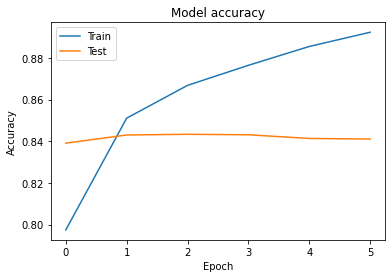

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

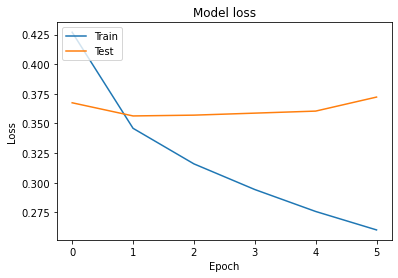

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3570 - acc: 0.8434

 테스트 정확도: 0.8434


In [41]:
## GRU로 네이버 영화 리뷰 감성 분류하기
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [42]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1934/1939 [============================>.] - ETA: 0s - loss: 0.3847 - acc: 0.8244
Epoch 00001: val_acc improved from -inf to 0.84609, saving model to best_model.h5
1939/1939 [==============================] - 18s 9ms/step - loss: 0.3848 - acc: 0.8244 - val_loss: 0.3487 - val_acc: 0.8461
Epoch 2/15
1936/1939 [============================>.] - ETA: 0s - loss: 0.3260 - acc: 0.8582
Epoch 00002: val_acc improved from 0.84609 to 0.85514, saving model to best_model.h5
1939/1939 [==============================] - 16s 8ms/step - loss: 0.3261 - acc: 0.8582 - val_loss: 0.3321 - val_acc: 0.8551
Epoch 3/15
1939/1939 [==============================] - ETA: 0s - loss: 0.3014 - acc: 0.8716
Epoch 00003: val_acc improved from 0.85514 to 0.85593, saving model to best_model.h5
1939/1939 [==============================] - 15s 8ms/step - loss: 0.3014 - acc: 0.8716 - val_loss: 0.3321 - val_acc: 0.8559
Epoch 4/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.2814 - acc: 0.8827
Epoc

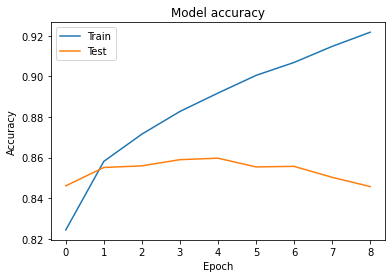

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

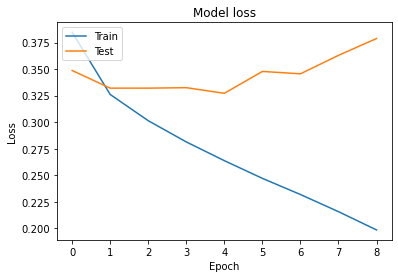

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 3s 2ms/step - loss: 0.3339 - acc: 0.8541

 테스트 정확도: 0.8541
